In [2]:
import os
from glob import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

In [3]:
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
from skimage.color import rgb2gray
from mpl_toolkits.axes_grid1 import ImageGrid

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
path='/content/drive/MyDrive/dataset_v4/images/'
cars_path=path+'cars/'
bikes_path=path+'motorcycles/'
no_vehicles_path=path+'non-vehicles/'

In [7]:
# fetching all the filenmaes to read them later
cars=np.array(glob(os.path.join(cars_path, '*.jpg')))
bikes=np.array(glob(os.path.join(bikes_path, '*.jpg')))
no_vehicles=np.array(glob(os.path.join(no_vehicles_path, '*.jpg')))
print('Number of car images', cars.size)
print('Number of bike images', bikes.size)
print('Number of no vehicle images', no_vehicles.size)

Number of car images 3520
Number of bike images 2000
Number of no vehicle images 2671


In [8]:
def load_images(img_path):# multichannel=False, width=128, height=64):
    images=[]
    for i in range(img_path.size):
        img=imread(img_path[i])
        images.append(img)
    return images

In [9]:
#Loading images
all_cars=load_images(cars)
all_bikes=load_images(bikes)
all_no_vehicles=load_images(no_vehicles)

In [10]:
def preprocessing(images, multichannel=False, width=128, height=64):
    preprocessed_images=[]
    if multichannel==False:
        for i in range(len(images)):
            gray_scaled=rgb2gray(images[i])
            resized=resize(gray_scaled,(width, height))
            preprocessed_images.append(resized)
    else:
        for i in range(len(images)):
            resized=resize(images[i],(width, height))
            preprocessed_images.append(resized)
    return preprocessed_images

In [11]:
def preprocess(image, multichannel=False, width=128, height=64):
    if multichannel==False:
            gray_scaled=rgb2gray(image)
            resized=resize(gray_scaled,(width, height))
            return resized
    else:
            resized=resize(image,(width, height))
            return resized

In [12]:
#Image Preprocessing
all_cars=preprocessing(all_cars)
all_bikes=preprocessing(all_bikes)
all_no_vehicles=preprocessing(all_no_vehicles)

### Classification using HOG Feature Descriptor

In [13]:
def HOG_Descriptor(images,orientations=9, pixels_per_cell=(8, 8), 
                   cells_per_block=(2,2),multichannel=False, visualize=False):
    fd_data=[]
    hog_images=[]
    if visualize == False:
        for i in range(len(images)):
            fd = hog(images[i], 
                     orientations=orientations, 
                     pixels_per_cell=pixels_per_cell,
                     cells_per_block=cells_per_block, 
                     visualize=False, 
                     multichannel=multichannel)
            fd_data.append(fd)
    else:
        for i in range(len(images)):
            fd, hog_image = hog(images[i], 
                     orientations=orientations, 
                     pixels_per_cell=pixels_per_cell,
                     cells_per_block=cells_per_block, 
                     visualize=True, 
                     multichannel=multichannel)
            fd_data.append(fd)
            hog_images.append(hog_image)
    return fd_data, hog_images

In [14]:
def HOG_image(image,orientations=9, pixels_per_cell=(8, 8), 
                   cells_per_block=(2,2),multichannel=False):
  fd = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell,
           cells_per_block=cells_per_block, 
           visualize=False, 
           multichannel=multichannel)
  return fd

In [17]:
# Getting HOG features of all car and bike images
hog_cars, hog_cars_images =HOG_Descriptor(all_cars)
hog_bikes, hog_bikes_images =HOG_Descriptor(all_bikes)
hog_no_vehicles, hog_no_vehicles_images =HOG_Descriptor(all_no_vehicles)

In [ ]:
def display_image_grid(images, num_rows, num_cols, title_text):

    fig = plt.figure(figsize=(num_cols*3., num_rows*3.), )
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.15)

    for ax, im in zip(grid, images):
        ax.imshow(im)
        ax.axis("off")
    
    plt.suptitle(title_text, fontsize=20)
    plt.show()

In [ ]:
#visualization
viz_images=[all_cars[0], all_bikes[0], all_no_vehicles[0]]
hog_viz, hog_viz_images=HOG_Descriptor(viz_images, visualize=True)

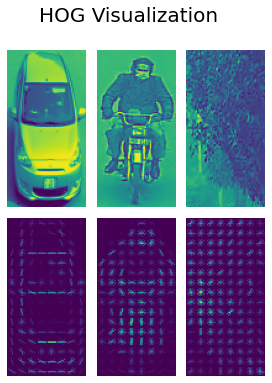

In [ ]:
display_image_grid(viz_images+hog_viz_images,2, len(viz_images), 'HOG Visualization')

In [129]:
#Generating Truth labels for car and bike images. We assign -1 to car data and 1 to bike data.
car_labels=list(np.ones(len(cars))*-1)
bikes_labels=list(np.ones(len(bikes)))
no_vehicles_labels=list(np.ones(len(no_vehicles))*2)

In [157]:
#Combining car and bike data together to make X_data and Y_data
X_data=hog_cars+hog_bikes+hog_no_vehicles
Y_data=car_labels+bikes_labels+no_vehicles_labels
print(len(X_data))
print(len(Y_data))

8191
8191


In [158]:
# Splitting whole data into train (80%) and test(20%).
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=12)

In [159]:
print('Training Samples',len(X_train))
print('Training Samples',len(y_train))
print('Testing Samples',len(X_test))
print('Testing Samples',len(y_test))

Training Samples 6552
Training Samples 6552
Testing Samples 1639
Testing Samples 1639


### Logistic regression Classification

In [160]:
# Training Logistic regression on train data
LR_model = LogisticRegression(random_state=12)
LR_model = LR_model.fit(X_train, y_train)

In [161]:
# Evaluation metrics of logistic regression on data using HOG features. 
LR_train_score=LR_model.score(X_train, y_train)
LR_y_pred=LR_model.predict(X_test)
LR_score=LR_model.score(X_test, y_test)
LR_f1_score=f1_score(y_test, LR_y_pred, average='weighted')
decimal_digits=4
print('Logistics Regression Evaluation')
print('Train Accuracy',round(LR_train_score,decimal_digits))
print('Test Accuracy',round(LR_score,decimal_digits))
print("%d mislabeled points out of %d test points" % ((y_test != LR_y_pred).sum(),len(X_test)))
print('f1 Score',round(LR_f1_score,decimal_digits))

Logistics Regression Evaluation
Train Accuracy 1.0
Test Accuracy 0.9939
10 mislabeled points out of 1639 test points
f1 Score 0.9939


### Gaussian Naive Bayes Classification

In [162]:
# Training Gaussian Naive Bayes on train data
GNB_model = GaussianNB()
GNB_model = GNB_model.fit(X_train, y_train)

In [163]:
# Evaluation metrics of Gaussian Naive Bayes on data using HOG features. 
GNB_train_score=GNB_model.score(X_train, y_train)
GNB_y_pred=GNB_model.predict(X_test)
GNB_score=GNB_model.score(X_test, y_test)
GNB_f1_score=f1_score(y_test, GNB_y_pred, average='weighted')
print('Gaussian Naive Bayes Evaluation')
print('Train Accuracy',round(GNB_train_score,decimal_digits))
print('Test Accuracy',round(GNB_score,decimal_digits))
print("%d mislabeled points out of %d test points" % ((y_test != GNB_y_pred).sum(),len(X_test)))
print('f1 Score',round(GNB_f1_score,decimal_digits))

Gaussian Naive Bayes Evaluation
Train Accuracy 0.9449
Test Accuracy 0.9439
92 mislabeled points out of 1639 test points
f1 Score 0.9443


### SVM Classification

In [164]:
# Training SVM with rbf kernel on train data
SVM_model = SVC(kernel='rbf', gamma='auto', C=1, random_state=12)#make_pipeline(StandardScaler(), SVC(gamma='auto'))
SVM_model=SVM_model.fit(X_train, y_train)

In [165]:
# Evaluation metrics of SVM with rbf kernel on data using HOG features. 
SVM_train_score=SVM_model.score(X_train, y_train)
SVM_y_pred=SVM_model.predict(X_test)
SVM_score=SVM_model.score(X_test, y_test)
SVM_f1_score=f1_score(y_test, SVM_y_pred, average='weighted')
print('SVM Evaluation')
print('Train Accuracy',round(SVM_train_score, decimal_digits))
print('Test Accuracy',round(SVM_score, decimal_digits))
print("%d mislabeled points out of %d test points" % ((y_test != SVM_y_pred).sum(),len(X_test)))
print('f1 Score',round(SVM_f1_score, decimal_digits))

SVM Evaluation
Train Accuracy 0.9667
Test Accuracy 0.9555
73 mislabeled points out of 1639 test points
f1 Score 0.9557


In [166]:
# Training SVM with polynomial kernel on train data
SVM_poly_model = SVC(kernel='poly', degree=3, gamma='auto', C=1, random_state=12)#make_pipeline(StandardScaler(), SVC(gamma='auto'))
SVM_poly_model=SVM_poly_model.fit(X_train, y_train)

In [167]:
# Evaluation metrics of SVM with polynomial kernel on data using HOG features. 
SVM_poly_train_score=SVM_poly_model.score(X_train, y_train)
SVM_poly_y_pred=SVM_poly_model.predict(X_test)
SVM_poly_score=SVM_poly_model.score(X_test, y_test)
SVM_poly_f1_score=f1_score(y_test, SVM_poly_y_pred, average='weighted')
print('SVM Evaluation')
print('Train Accuracy',round(SVM_poly_train_score, decimal_digits))
print('Test Accuracy',round(SVM_poly_score, decimal_digits))
print("%d mislabeled points out of %d test points" % ((y_test != SVM_poly_y_pred).sum(),len(X_test)))
print('f1 Score',round(SVM_poly_f1_score, decimal_digits))

SVM Evaluation
Train Accuracy 0.4299
Test Accuracy 0.4289
936 mislabeled points out of 1639 test points
f1 Score 0.2575


### Neural Network Classification

In [149]:
#using MLP classifier 
neural = MLPClassifier(activation='relu', alpha=.0001, hidden_layer_sizes=(256, 128, 3), random_state=1, 
                    max_iter=1000)
scaler = neural.fit(X_train, y_train)



In [134]:
#Evaluation metrics of MLP classifier using HOG features
train_score = neural.score(X_train, y_train)
test_score = neural.score(X_test, y_test)
neural_y_pred = neural.predict(X_test)
neural_f1  = f1_score(y_test, neural_y_pred, average='weighted')

print("Train accuracy: ", train_score)
print("Test accuracy: ",test_score)
print("%d mislabeled points out of %d test points" % ((y_test != neural_y_pred).sum(),len(X_test)))
print("f1 score: ", neural_f1)

Train accuracy:  0.9998473748473748
Test accuracy:  0.9865771812080537
22 mislabeled points out of 1639 test points
f1 score:  0.9865857980879392


## Classification using Histogram Feature Descriptor

In [135]:
def hist_Descriptor(images):
    hist_data=[]
    for i in range(len(images)):
        hist, bin_edges=np.histogram(images[i], bins=256, range=(0, 1))
        hist_data.append(hist)
    return hist_data    

In [136]:
# Getting Histogram features of all car and bike images
hist_cars=hist_Descriptor(all_cars)
hist_bikes=hist_Descriptor(all_bikes)
hist_no_vehicles=hist_Descriptor(all_no_vehicles)

Text(0, 0.5, 'Number of pixel values')

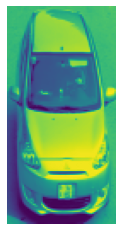

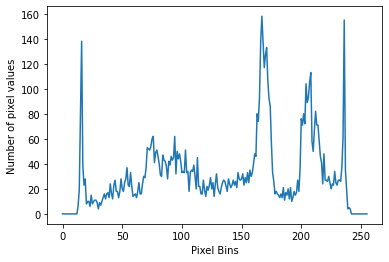

In [ ]:
plt.figure(1)
plt.imshow(all_cars[0])
plt.axis("off")
plt.figure(2)
plt.plot(hist_cars[0])
plt.xlabel('Pixel Bins')
plt.ylabel('Number of pixel values')

In [137]:
#Generating Truth labels for car and bike images. We assign -1 to car data and 1 to bike data.
car_labels=list(np.ones(len(cars))*-1)
bikes_labels=list(np.ones(len(bikes)))
no_vehicles_labels=list(np.ones(len(no_vehicles))*2)

In [168]:
#Combining car and bike data together to make X_data and Y_data
X_data=hist_cars+hist_bikes+hist_no_vehicles
Y_data=car_labels+bikes_labels+no_vehicles_labels
print(len(X_data))
print(len(Y_data))

8191
8191


In [169]:
# Splitting whole data into train (80%) and test(20%).
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=12)

In [170]:
# Number of features in each sample using Histogram.
X_train[0].shape

(256,)

In [171]:
print('Training Samples',len(X_train))
print('Training Samples',len(y_train))
print('Testing Samples',len(X_test))
print('Testing Samples',len(y_test))

Training Samples 6552
Training Samples 6552
Testing Samples 1639
Testing Samples 1639


### Logistic Regression Classification

In [172]:
# Training Logistic regression on train data
LR_model = LogisticRegression(random_state=12)
LR_model = LR_model.fit(X_train, y_train)

In [173]:
# Evaluation metrics of logistic regression on data using Histogram features. 
LR_train_score=LR_model.score(X_train, y_train)
LR_y_pred=LR_model.predict(X_test)
LR_score=LR_model.score(X_test, y_test)
LR_f1_score=f1_score(y_test, LR_y_pred, average='weighted')
decimal_digits=4
print('Logistics Regression Evaluation')
print('Train Accuracy',round(LR_train_score,decimal_digits))
print('Test Accuracy',round(LR_score,decimal_digits))
print("%d mislabeled points out of %d test points" % ((y_test != LR_y_pred).sum(),len(X_test)))
print('f1 Score',round(LR_f1_score,decimal_digits))

Logistics Regression Evaluation
Train Accuracy 0.8378
Test Accuracy 0.7913
342 mislabeled points out of 1639 test points
f1 Score 0.7891


### Gaussian Naive Bayes Classification

In [174]:
# Training Gaussian Naive Bayes on train data
GNB_model = GaussianNB()
GNB_model = GNB_model.fit(X_train, y_train)

In [175]:
# Evaluation metrics of Gaussian Naive bayes on data using Histogram features. 
GNB_train_score=GNB_model.score(X_train, y_train)
GNB_y_pred=GNB_model.predict(X_test)
GNB_score=GNB_model.score(X_test, y_test)
GNB_f1_score=f1_score(y_test, GNB_y_pred, average='weighted')
print('Gaussian Naive Bayes Evaluation')
print('Train Accuracy',round(GNB_train_score,decimal_digits))
print('Test Accuracy',round(GNB_score,decimal_digits))
print("%d mislabeled points out of %d test points" % ((y_test != GNB_y_pred).sum(),len(X_test)))
print('f1 Score',round(GNB_f1_score,decimal_digits))

Gaussian Naive Bayes Evaluation
Train Accuracy 0.736
Test Accuracy 0.7334
437 mislabeled points out of 1639 test points
f1 Score 0.73


### SVM Classification

In [176]:
# Training SVM with rbf kernel on train data
SVM_model = SVC(kernel='rbf', gamma='auto', C=1, random_state=12)#make_pipeline(StandardScaler(), SVC(gamma='auto'))
SVM_model=SVM_model.fit(X_train, y_train)

In [177]:
# Evaluation metrics of SVM with rbf kernel on data using Histogram features.  
SVM_train_score=SVM_model.score(X_train, y_train)
SVM_y_pred=SVM_model.predict(X_test)
SVM_score=SVM_model.score(X_test, y_test)
SVM_f1_score=f1_score(y_test, SVM_y_pred, average='weighted')
print('SVM Evaluation')
print('Train Accuracy',round(SVM_train_score, decimal_digits))
print('Test Accuracy',round(SVM_score, decimal_digits))
print("%d mislabeled points out of %d test points" % ((y_test != SVM_y_pred).sum(),len(X_test)))
print('f1 Score',round(SVM_f1_score, decimal_digits))

SVM Evaluation
Train Accuracy 1.0
Test Accuracy 0.4387
920 mislabeled points out of 1639 test points
f1 Score 0.2783


In [178]:
# Training SVM with polynomial kernel
SVM_poly_model = SVC(kernel='poly', degree=3, gamma='auto', C=1, random_state=12)#make_pipeline(StandardScaler(), SVC(gamma='auto'))
SVM_poly_model=SVM_poly_model.fit(X_train, y_train)

In [179]:
# Evaluation metrics of SVM with polynomial kernel on data using Histogram features. 
SVM_poly_train_score=SVM_poly_model.score(X_train, y_train)
SVM_poly_y_pred=SVM_poly_model.predict(X_test)
SVM_poly_score=SVM_poly_model.score(X_test, y_test)
SVM_poly_f1_score=f1_score(y_test, SVM_poly_y_pred, average='weighted')
print('SVM Evaluation')
print('Train Accuracy',round(SVM_poly_train_score, decimal_digits))
print('Test Accuracy',round(SVM_poly_score, decimal_digits))
print("%d mislabeled points out of %d test points" % ((y_test != SVM_poly_y_pred).sum(),len(X_test)))
print('f1 Score',round(SVM_poly_f1_score, decimal_digits))

SVM Evaluation
Train Accuracy 1.0
Test Accuracy 0.8999
164 mislabeled points out of 1639 test points
f1 Score 0.8997


###Neural Networks

In [141]:
neural = MLPClassifier(activation='relu', alpha=.0001, hidden_layer_sizes=(256, 128, 3), random_state=1, 
                    max_iter=1000)
scaler = neural.fit(X_train, y_train)

#Evaluation metrics of MLP classifier using histogram
train_score = neural.score(X_train, y_train)
test_score = neural.score(X_test, y_test)
neural_y_pred = neural.predict(X_test)
neural_f1  = f1_score(y_test, neural_y_pred, average='weighted')

print("Train accuracy: ", train_score)
print("Test accuracy: ",test_score)
print("%d mislabeled points out of %d test points" % ((y_test != neural_y_pred).sum(),len(X_test)))
print("f1 score: ", neural_f1)

Train accuracy:  0.9974053724053724
Test accuracy:  0.9267846247712019
120 mislabeled points out of 1639 test points
f1 score:  0.927128150611253



# Sliding Window

In [ ]:
'''
I have used two implementations of the sliding window for this project.
1. Picks frames from the video and divides the frame into windows. Each window of the image is cropped,
and ran through a classifier and hence eevry window of the frame is classified as either, bike, car or 
non-vehicle. I tried compiling all the frames back into one video but that was unsuccessful. 

2. I have implemented the method shared in the resources which uses a pyramid and moves the sliding window. Then
we use a classifier over the window to classify the images. 
'''

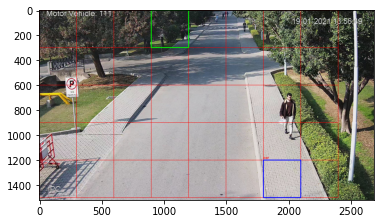

In [103]:
from ssl import OP_NO_TICKET
# Method 1

def detect(image):
  plt.imshow
  tmp = image
  tmp3 = image
  tmp2 = im.fromarray(tmp)

  width,height= (300,300)
  x = 0
  y = 0
  step=300
  allwindows = []
  final=0

  for x in range(0, image.shape[1] - width , step):
    for y in range(0, image.shape[0] - height, step):
      window = image[x:x + width, y:y + height, :]
      allwindows.append([x,y,x+width, y+height]) #saving the right,left,top.bottom coordinates of each image
      final = cv.rectangle(tmp, (x, y), (x + width, y + height), (255, 0, 0), 2) # draw rectangle on image

#plt.imshow(np.array(tmp).astype('uint8'))
# I have divided the image into small windows using the above technique
#I have a temp image thats divided into pieces, I will select each piece run it 
#through the classifier and label as bike, car or non-vehicle on the orginial image

  images=[]
  for i in range(len(allwindows)):
    im1 = tmp2.crop((allwindows[i][0],allwindows[i][1],allwindows[i][2],allwindows[i][3])) # this is one of the cropped images from the windows created
    images.append(im1)
  #plt.imshow(im1)

#now that we have all the windows, we clsssify them
#take out the hog features of the images

  for i in range(len(images)):
    images[i] = np.array(images[i])
  images = preprocessing(images)
  hog_features,images = HOG_Descriptor(images)

#Now we apply the classfier on each image to classify into one of the categories

  prediction_neural = neural.predict(hog_features)
  predicion_logicalreg = LR_model.predict(hog_features)
  prediction_GB = GNB_model.predict(hog_features)
  prediction_SVM = SVM_model.predict(hog_features)

  for i in range(len(prediction_neural)):
    if prediction_neural[i] == 1:
    #draw the rectangle on original image and label each image
    # windows that detect a bike are green, car are blue and the non vehicle windows are red
      cv.rectangle(tmp3, (allwindows[i][0],allwindows[i][1]), (allwindows[i][2],allwindows[i][3]), (0, 255, 0), 6)
      cv.putText(image, 'bike', (allwindows[i][0],allwindows[i][1]-10),cv.FONT_HERSHEY_SIMPLEX, 0.9,   (255, 0, 0), 2)
    elif prediction_neural[i] == -1:
      cv.rectangle(image, (allwindows[i][0],allwindows[i][1]), (allwindows[i][2],allwindows[i][3]), (0, 0, 255), 6)
      cv.putText(tmp3, 'car', (allwindows[i][0],allwindows[i][1]-10),cv.FONT_HERSHEY_SIMPLEX, 0.9,   (255, 0, 0), 2)

  plt.imshow(np.array(tmp3).astype('uint8'))
  return tmp3

output = '/content/drive/MyDrive/dataset_v4/final_video/result.mp4'
vidc = cv.VideoCapture('/content/drive/MyDrive/dataset_v4/sample videos/sample.mp4')
ok, image = vidc.read()
count = 0

#this divides the sample video into many frames
frames = []
while ok:
  cv.imwrite("/content/drive/MyDrive/dataset_v4/final_video/frame%d.jpg" % count, image)     # save frame as JPEG file
  frames.append("frame"+str(count)+".jpg")      
  ok,image = vidc.read()
  #print('Read a new frame: ', success)
  count += 1

#on all the new images created apply the detection function, this output each image w its windows marked
count = count-1
img_arr =[]
for i in range(count):
  location = "/content/drive/MyDrive/dataset_v4/final_video/frame"+str(count)+".jpg/"
  img = imread(location)
  final = detect(img)
  img_arr.append(final)



In [88]:
#I have used this to recompile the frames on which I applied a sliding window into one video but it was not successful
output_vid = cv.VideoWriter('/content/drive/MyDrive/dataset_v4/final_video/final.avi',cv.VideoWriter_fourcc(*'MJPG'), 15, (300,300))
 
for i in range(len(img_arr)):
    output_vid.write(img_arr[i])

cv.destroyAllWindows
output_vid.release()

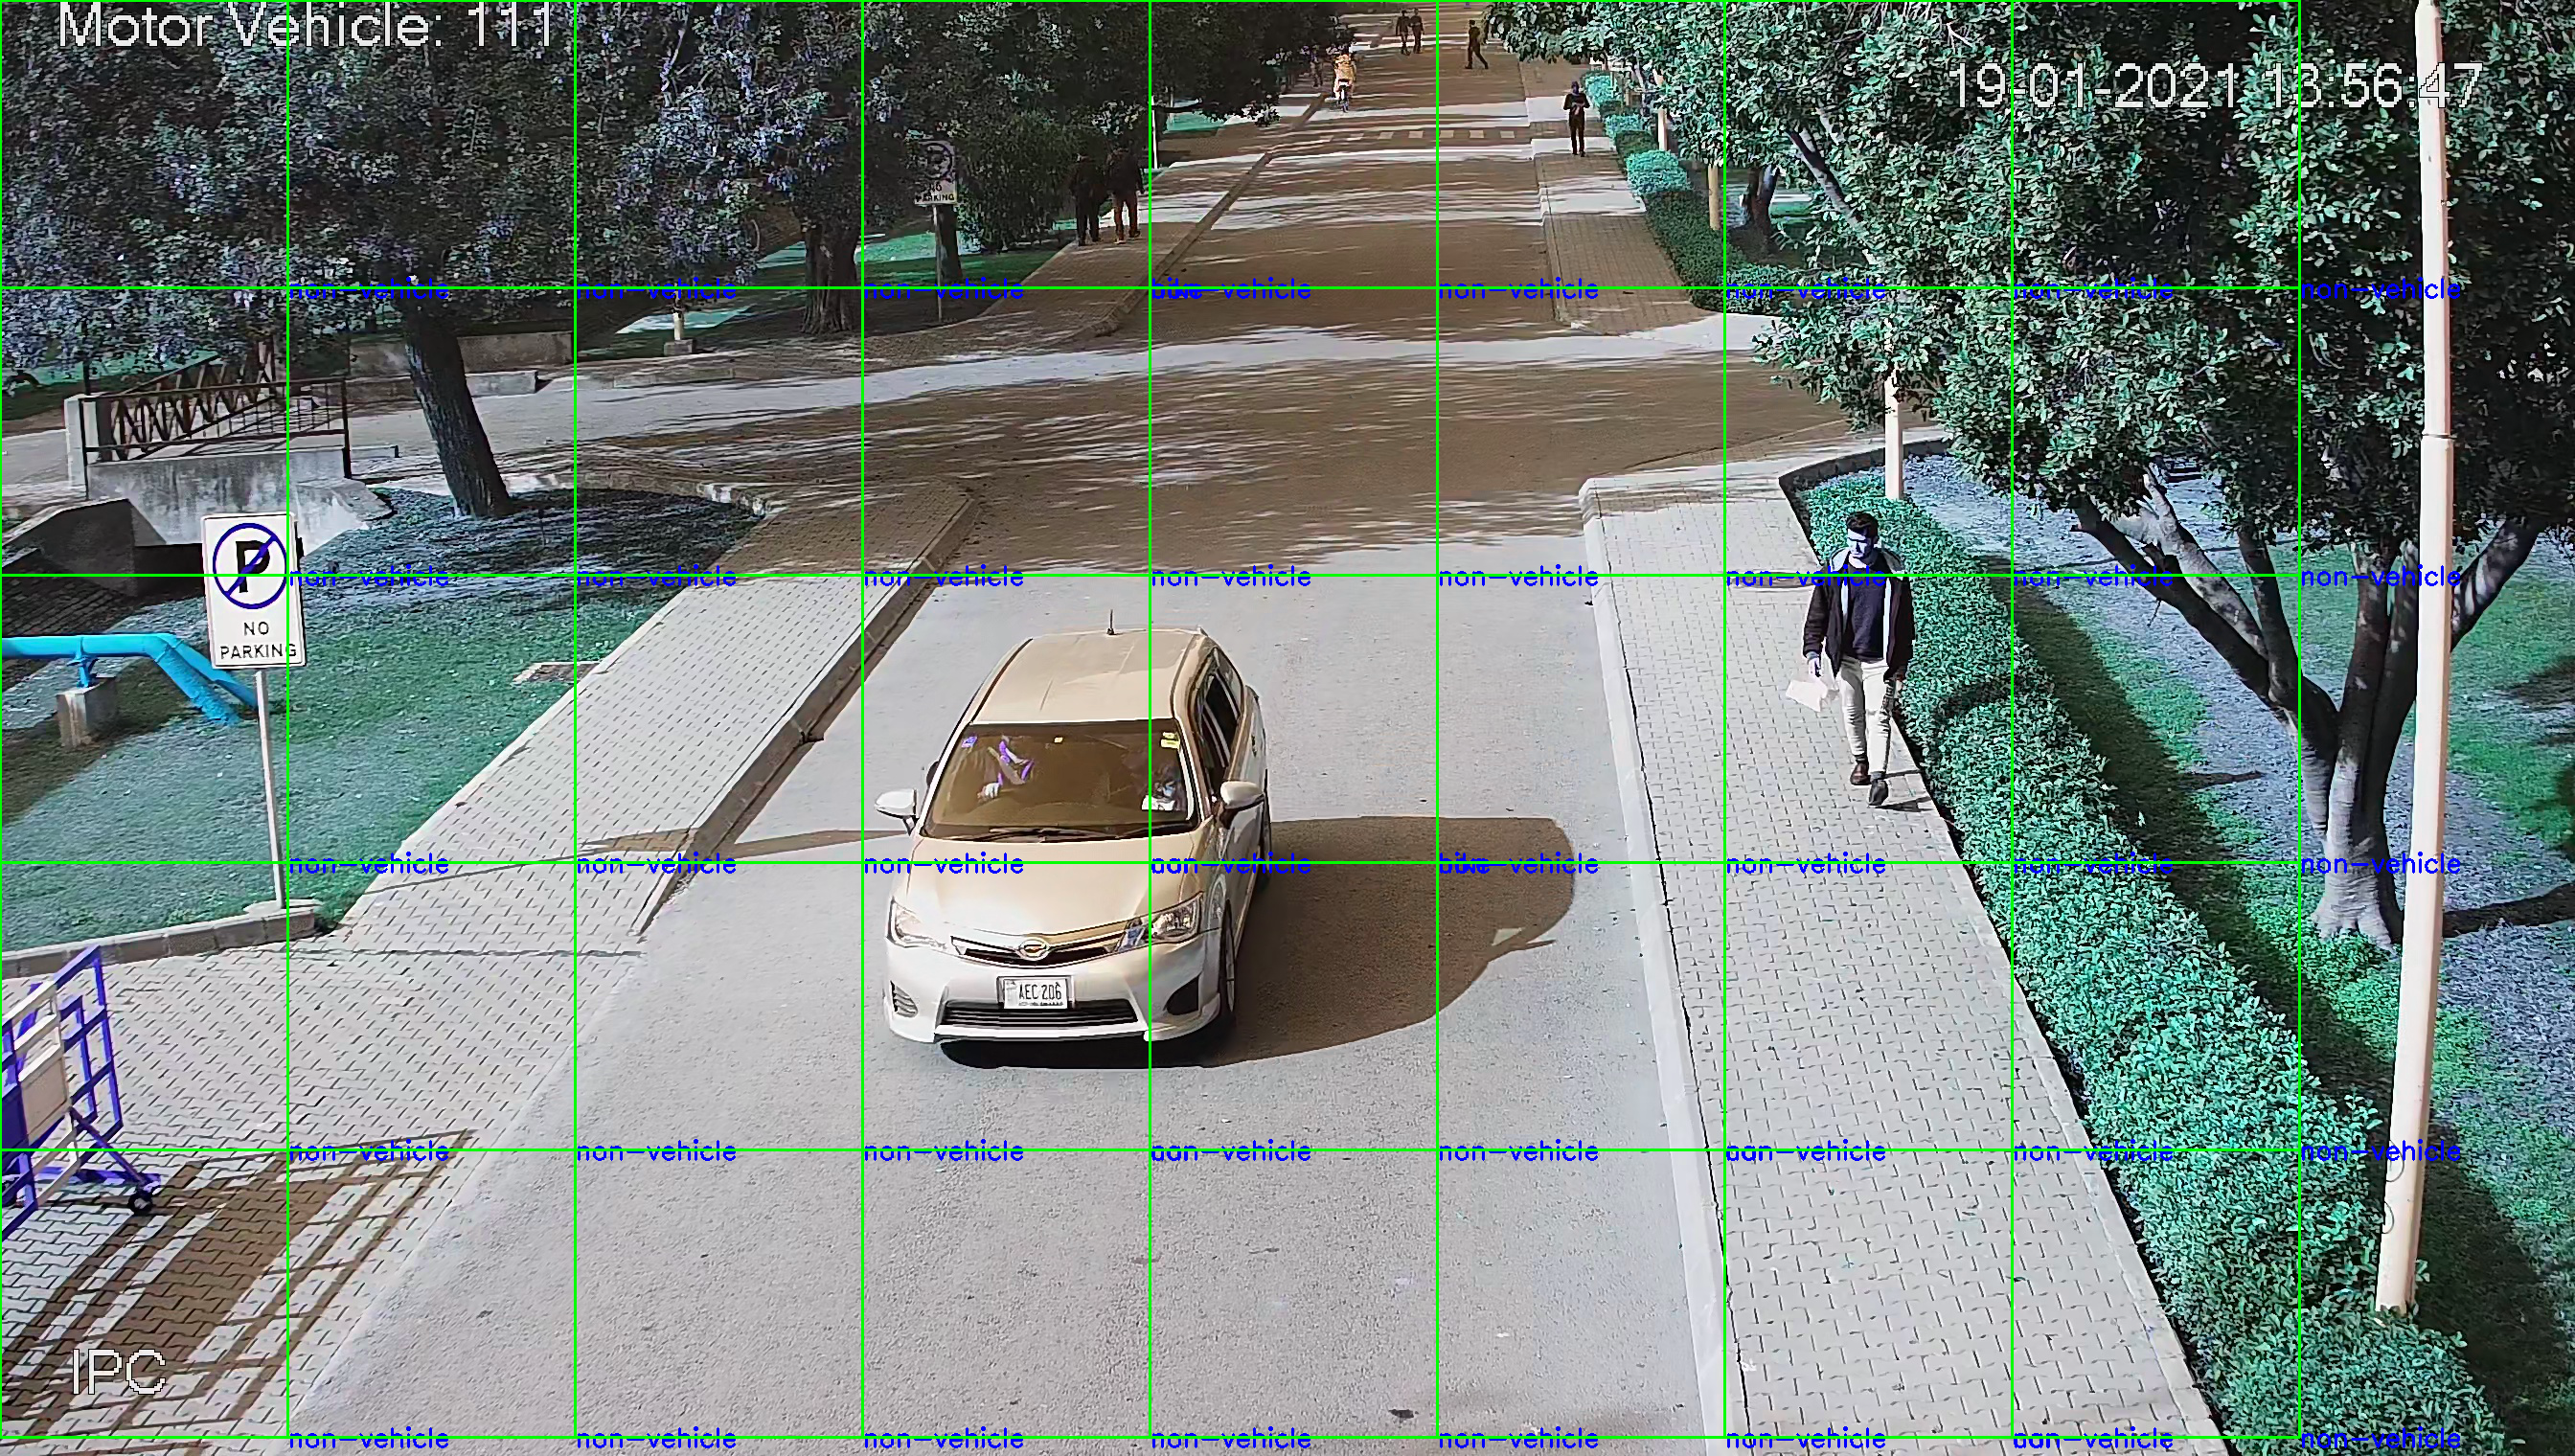

In [156]:
#Method 2

image = imread('/content/drive/MyDrive/Screenshot 2022-05-01 at 4.09.39 PM.png')

import imutils
import time
from google.colab.patches import cv2_imshow
width,height= (300,300)

def pyramid(image, scale=1.5, min=(30, 30)):
	yield image
	while True:
		new_dimension = int(image.shape[1] / scale)
		image = imutils.resize(image, width=new_dimension)
		if image.shape[0] < min[1] or image.shape[1] < min[0]:
			break
		yield image

def sliding_window(image,step,window):
  tmp = image
  tmp2 = im.fromarray(tmp)
  width,height= (300,300)

  step=300
  allwindows = []
  final=0
  for y in range(0, image.shape[0], step):
    for x in range(0, image.shape[1], step):
      yield (x, y, image[y:y + window[1], x:x + window[0]])

neural_lis=[]
gb=[]
svm=[]
regression=[]
def detect(image):
  width,height= (300,300)
  for pyr_img in pyramid(image, scale=1.5):
    for x,y,w in sliding_window(image,32,window=(width,height)):
      if w.shape[0] != height or w.shape[1] != width:
        continue
		
      image = preprocess(w)
      hog_features = HOG_image(image)

  #Now we apply the classfier on each image to classify into one of the categories

      prediction_neural = neural.predict([hog_features])
      predicion_logicalreg = LR_model.predict([hog_features])
      prediction_GB = GNB_model.predict([hog_features])
      prediction_SVM = SVM_model.predict([hog_features])
      classify=0
      classify1=0
      classify2=0
      classify3=0
      
      #classification by neural networks
      for i in range(len(prediction_neural)):
        if prediction_neural[i] == 1:
      #draw the rectangle on original image and label each image
      # windows that detect a bike are green, car are blue and the non vehicle windows are red
          classify ='bike'
        elif prediction_neural[i] == -1:
          classify='car'
      
        copy_of_w = pyr_img
        cv.rectangle(copy_of_w, (x, y), (x + width, y + height), (0, 255, 0), 2)
        if classify=='bike':
          cv.putText(copy_of_w, 'bike', (x+width, y+height+10), cv.FONT_HERSHEY_SIMPLEX, 0.9,   (255, 0, 0), 2)
        elif classify=='car':
          cv.putText(copy_of_w, 'car', (x+width, y+height+10), cv.FONT_HERSHEY_SIMPLEX, 0.9,   (255, 0, 0), 2)
        else:
          cv.putText(copy_of_w, 'non-vehicle',  (x+width, y+height+10), cv.FONT_HERSHEY_SIMPLEX, 0.9,   (255, 0, 0), 2)

        neural_lis.append(copy_of_w)

      #classification by Naive bayes
      for i in range(len(prediction_GB)):
        if prediction_GB[i] == 1:
      #draw the rectangle on original image and label each image
      # windows that detect a bike are green, car are blue and the non vehicle windows are red
          classify1 ='bike'
        elif prediction_GB[i] == -1:
          classify1='car'
      
        copy_of_w1 = pyr_img
        cv.rectangle(copy_of_w1, (x, y), (x + width, y + height), (0, 255, 0), 2)
        if classify1=='bike':
          cv.putText(copy_of_w1, 'bike', (x+width, y+height+10), cv.FONT_HERSHEY_SIMPLEX, 0.9,   (255, 0, 0), 2)
        elif classify1=='car':
          cv.putText(copy_of_w1, 'car', (x+width, y+height+10), cv.FONT_HERSHEY_SIMPLEX, 0.9,   (255, 0, 0), 2)
        else:
          cv.putText(copy_of_w1, 'non-vehicle',  (x+width, y+height+10), cv.FONT_HERSHEY_SIMPLEX, 0.9,   (255, 0, 0), 2)

        gb.append(copy_of_w1)

        #using SVM
      for i in range(len(prediction_SVM)):
        if prediction_SVM[i] == 1:
      #draw the rectangle on original image and label each image
      # windows that detect a bike are green, car are blue and the non vehicle windows are red
          classify2 ='bike'
        elif prediction_SVM[i] == -1:
          classify2='car'
      
        copy_of_w2 = pyr_img
        cv.rectangle(copy_of_w2, (x, y), (x + width, y + height), (0, 255, 0), 2)
        if classify2=='bike':
          cv.putText(copy_of_w2, 'bike', (x+width, y+height+10), cv.FONT_HERSHEY_SIMPLEX, 0.9,   (255, 0, 0), 2)
        elif classify2=='car':
          cv.putText(copy_of_w2, 'car', (x+width, y+height+10), cv.FONT_HERSHEY_SIMPLEX, 0.9,   (255, 0, 0), 2)
        else:
          cv.putText(copy_of_w2, 'non-vehicle',  (x+width, y+height+10), cv.FONT_HERSHEY_SIMPLEX, 0.9,   (255, 0, 0), 2)

        svm.append(copy_of_w2)

      for i in range(len(predicion_logicalreg)):
        if predicion_logicalreg[i] == 1:
      #draw the rectangle on original image and label each image
      # windows that detect a bike are green, car are blue and the non vehicle windows are red
          classify3 ='bike'
        elif predicion_logicalreg[i] == -1:
          classify3='car'
      
        copy_of_w3 = pyr_img
        cv.rectangle(copy_of_w3, (x, y), (x + width, y + height), (0, 255, 0), 2)
        if classify3=='bike':
          cv.putText(copy_of_w3, 'bike', (x+width, y+height+10), cv.FONT_HERSHEY_SIMPLEX, 0.9,   (255, 0, 0), 2)
        elif classify3=='car':
          cv.putText(copy_of_w3, 'car', (x+width, y+height+10), cv.FONT_HERSHEY_SIMPLEX, 0.9,   (255, 0, 0), 2)
        else:
          cv.putText(copy_of_w3, 'non-vehicle',  (x+width, y+height+10), cv.FONT_HERSHEY_SIMPLEX, 0.9,   (255, 0, 0), 2)

        regression.append(copy_of_w3)
        #cv2_imshow(copy_of_w)
        #cv.waitKey(1)
        #time.sleep(0.025)
        #the above commands don't all fit into the notebook so I have printed the last window only below

  cv2_imshow(neural_lis[len(neural_lis)-1])
  # the following can be uncommented to observe the sliding window for the rest fo the classifiers
  #cv2_imshow(gb[len(gb)-1])
  #cv2_imshow(svm[len(svm)-1])
  #cv2_imshow(regression[len(regression)-1])
#Applying this method to only one image from the frame I divided the video into
location = "/content/drive/MyDrive/dataset_v4/final_video/frame"+str(45)+".jpg/"
img = imread(location)
final = detect(img)
